In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import baseGrafo
import random
import math
import os
import random
import statistics
from utils import ler_grafo_dimacs, ler_solucoes_otimas, salvar_resultados

In [ ]:
baseGrafo.grafoImport(30)

14849


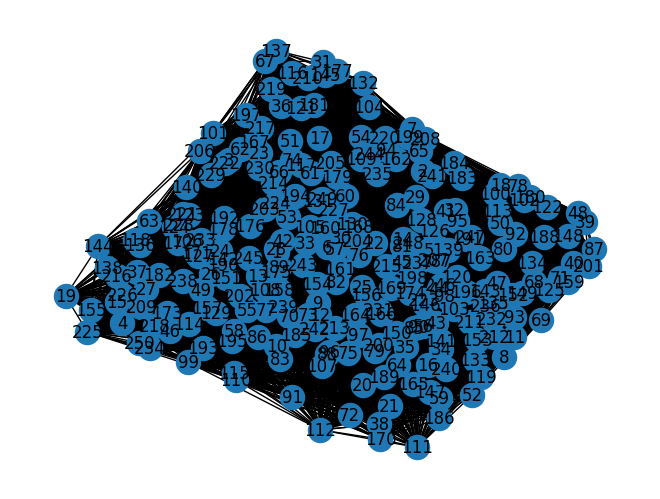

In [2]:
pasta_grafos = "grafos"
resultados_dir = "resultados"
os.makedirs(resultados_dir, exist_ok=True)

solucoes_otimas = ler_solucoes_otimas("solucoes_otimas.csv")

G = ler_grafo_dimacs(os.path.join("grafos", "r250.5.col"))
print(G.number_of_edges())
nx.draw(G, with_labels=True)      

In [ ]:
G = nx.read_edgelist("grafoBase.csv", delimiter=",")
G = nx.relabel_nodes(G, lambda x: int(x))
print(list(G.neighbors(2)))

nx.draw_circular(G, with_labels=True)

In [ ]:

def custos(coloring):
        # Conta o número de conflitos (nós adjacentes com mesma cor)
        conflitos = sum(1 for u, v in G.edges() if coloring[u] == coloring[v])
        return conflitos

def simulated_annealing_coloringe(G, max_iter=50000, i_temp=1000, cooling_rate=0.995):
   # Inicializa coloração aleatória
    coloring, n_colors = baseGrafo.heuristicaGulosa(G)
    
    current_custo = custos(coloring)
    best_coloring = coloring.copy()
    best_custo_i = current_custo # Pego dados da solução inicial feita pela heuristica

    for node in coloring:
        if coloring[node] >= n_colors:
            coloring[node] = random.randint(0, n_colors - 1)
    
    current_custo = custos(coloring) 
    best_custo = current_custo
    print("solução inicial tem", n_colors+1, "cores")

    temp = i_temp
    f_colors = n_colors
    flag = False
    
    while(temp > 10):
        for i in range(max_iter):
            node = random.choice(list(G.nodes()))
            old_color = coloring[node]
            nova_cor = random.randint(0, n_colors-1)
            coloring[node] = nova_cor
                
            new_custo = custos(coloring)

            dif = new_custo - current_custo
                
            if dif < 0 or random.random() < math.exp(-dif / temp):
                # Aceita nova solução
                current_custo = new_custo
                #print("novo custo atual", current_custo)
                if new_custo < best_custo:
                    best_coloring = coloring.copy()
                    best_custo = new_custo
                    print("novo melhor custo", best_custo)
                else:
                    # Reverte mudança
                    coloring[node] = old_color

                # Opcional: parar se custo for 0 e tentar com menos cores(sem conflitos)
            if best_custo == 0:
                best_coloring_i = best_coloring
                print("convergiu em 0, com", n_colors,"cores", "na iteracao", i)
                f_colors =  n_colors # qtd de cores de quando houve o encontro da resposta viavel
                n_colors -= 1
                best_custo_i = best_custo # numero de convergencia
                for node in coloring:
                    if coloring[node] >= n_colors:
                        coloring[node] = random.randint(0, n_colors - 1)
                    
                best_custo = custos(coloring)
                temp = i_temp
                current_custo = best_custo
                print("temperatura:", temp)
                flag = True
                break


    # Atualiza temperatura
        temp *= cooling_rate

    return best_coloring_i, best_custo_i, f_colors

# Exemplo de uso
coloring, custo_final, cores= simulated_annealing_coloringe(G)

print('Coloração final:', coloring)
print(cores, 'cores')
print('Conflitos restantes:', custo_final)

In [ ]:
def custo(coloring):
        # Conta o número de conflitos (nós adjacentes com mesma cor)
        conflitos = sum(1 for u, v in G.edges() if coloring[u] == coloring[v])
        return conflitos

def simulated_annealing_colorings(G, max_iter=500000, i_temp=12400, cooling_rate=0.995):
   # Inicializa coloração aleatória
    coloring, n_colors = baseGrafo.heuristicaGulosa(G)
    k = 0
    current_custo = custo(coloring)
    best_coloring = coloring.copy()
    best_custo_i = current_custo # Pego dados da solução inicial feita pela heuristica

    for node in coloring:
        if coloring[node] >= n_colors:
            coloring[node] = random.randint(0, n_colors - 1)
    
    current_custo = custo(coloring) 
    best_custo = current_custo
    print("solução inicial tem", n_colors+1, "cores")
    print("best custo", best_custo)
    temp = i_temp
    f_colors = n_colors
    flag = False
    v = int(250 * 0.05 * (temp/i_temp))
    print(v)
    for i in range(max_iter):
        if(temp < 0.0005):
           i_temp = i_temp*1.1
           temp = i_temp
           print("temperatura muito baixa, adicionando 10%", temp)
            
        percentual = 0.05  # até 5% dos nós
        k = max(1, int(250 * percentual * (temp / i_temp)))
        if(v>k):
            print(v," nós mudados")
            v -=v
        
        nodes = random.sample(list(G.nodes()), k)

        # Armazenar cores antigas para possível rollback
        old_colors = {node: coloring[node] for node in nodes}

        # Aplica novas cores aleatórias
        for node in nodes:
            nova_cor = random.randint(0, n_colors - 1)
            coloring[node] = nova_cor
        
        new_custo = custo(coloring)

        dif = new_custo - current_custo
        
        if dif < 0 or random.random() < math.exp(-dif / temp):
            # Aceita nova solução
            current_custo = new_custo
            if new_custo < best_custo:
                best_coloring = coloring.copy()
                best_custo = new_custo
                print("achou melhor custo", best_custo, " temperatura", temp)
        else:
            # Reverte mudança
            for node in nodes:
                coloring[node] = old_colors[node]

        # Opcional: parar se custo for 0 e tentar com menos cores(sem conflitos)
        if best_custo == 0:
            best_coloring_i = coloring.copy()
            print("convergiu em 0, com", n_colors,"cores", "na iteracao", i)
            f_colors =  n_colors # qtd de cores de quando houve o encontro da resposta viavel
            k += 1
            best_custo_i = best_custo # numero de convergencia
            for node in nodes:
                nova_cor = random.randint(0, n_colors - 1)
                coloring[node] = nova_cor
            
            print("temperatura:", temp)
            best_custo = custo(coloring)
            temp = i_temp
            current_custo = best_custo
            
            flag = True

        if i == max_iter-1 and flag == False:
            best_coloring_i = best_coloring
            best_custo_i = best_custo
            print("bateu o ponto")
            print("temperatura:", temp)
        
        # Atualiza temperatura
        if(temp == 200):
            print("iteração", i)
        temp *= cooling_rate

    return best_coloring_i, best_custo_i, k

# Exemplo de uso
coloring, custo_final, acertos= simulated_annealing_colorings(G)

print('Coloração final:', coloring)
print(acertos, 'acertos')
print('Conflitos restantes:', custo_final)

In [ ]:
def custo(coloring):
        # Conta o número de conflitos (nós adjacentes com mesma cor)
        conflitos = sum(1 for u, v in G.edges() if coloring[u] == coloring[v])
        return conflitos

def simulated_annealing_coloring(G, max_iter=500000, i_temp=12400, cooling_rate=0.995):
   # Inicializa coloração aleatória
    coloring, n_colors = baseGrafo.heuristicaGulosa(G)
    
    current_custo = custo(coloring)
    best_coloring = coloring.copy()
    best_custo_i = current_custo # Pego dados da solução inicial feita pela heuristica

    for node in coloring:
        if coloring[node] >= n_colors:
            coloring[node] = random.randint(0, n_colors - 1)
    
    current_custo = custo(coloring) 
    best_custo = current_custo
    print("solução inicial tem", n_colors+1, "cores")
    print("best custo", best_custo)
    temp = i_temp
    f_colors = n_colors
    flag = False
    checkpoint = 0
    for i in range(max_iter):
        percentual = 0.05 # até 10% dos nós
        k = max(1, int(G.number_of_nodes() * percentual * (temp / i_temp)))

        nodes = random.sample(list(G.nodes()), k)

        # Armazenar cores antigas para possível rollback
        old_colors = {node: coloring[node] for node in nodes}

        # Aplica novas cores aleatórias
        for node in nodes:
            nova_cor = random.randint(0, n_colors - 1)
            coloring[node] = nova_cor
        
        new_custo = custo(coloring)

        dif = new_custo - current_custo
        
        if dif < 0 or random.random() < math.exp(-dif / temp):
            # Aceita nova solução
            current_custo = new_custo
            if new_custo < best_custo:
                best_coloring = coloring.copy()
                best_custo = new_custo
                print("achou melhor custo", best_custo, " temperatura", temp)
                checkpoint = i
        else:
            # Reverte mudança
            for node in nodes:
                coloring[node] = old_colors[node]

        # Opcional: parar se custo for 0 e tentar com menos cores(sem conflitos)
        if best_custo == 0:
            best_coloring_i = coloring.copy()
            print("convergiu em 0, com", n_colors,"cores", "na iteracao", i)
            f_colors =  n_colors # qtd de cores de quando houve o encontro da resposta viavel
            n_colors -= 1
            best_custo_i = best_custo # numero de convergencia
            for node in coloring:
                if coloring[node] >= n_colors:
                    coloring[node] = random.randint(0, n_colors - 1)
            
            print("temperatura:", temp)
            best_custo = custo(coloring)
            temp = i_temp
            current_custo = best_custo
            
            flag = True

        if i == max_iter-1 and flag == False:
            best_coloring_i = best_coloring
            best_custo_i = best_custo
            print("bateu o ponto")
            print("temperatura:", temp)
        
        # Atualiza temperatura
        if(i%100000 == 0):
            if(checkpoint - i > 50000):
                temp = i_temp/3
        temp *= cooling_rate

    return best_coloring_i, best_custo_i, f_colors

# Exemplo de uso
coloring, custo_final, cores= simulated_annealing_coloring(G)

print('Coloração final:', coloring)
print(cores, 'cores')
print('Conflitos restantes:', custo_final)

250
solução inicial tem 79 cores
best custo 3
temperatura 12400
temperatura 2.1097409976888298e-18
temperatura 3.5895218365557233e-40
temperatura 6.107226919903999e-62
achou melhor custo 2  temperatura 1.9609993444845323e-63
temperatura 1.039086049605681e-83
achou melhor custo 1  temperatura 7.56424444811341e-105
temperatura 1.7679051927255217e-105
achou melhor custo 0  temperatura 2.0446389885646098e-116
convergiu em 0, com 78 cores na iteracao 55024
temperatura: 2.0446389885646098e-116
temperatura 1.8241959025434076e-07
temperatura 3.103694260815957e-29
temperatura 5.2806379244637255e-51
achou melhor custo 5  temperatura 3.259420220544203e-64
temperatura 8.984498647735223e-73
achou melhor custo 4  temperatura 3.3060894087696903e-80
temperatura 1.528626221032821e-94
achou melhor custo 3  temperatura 1.662341080757072e-96
achou melhor custo 2  temperatura 7.727909488760634e-103
temperatura 2.600810813431542e-116
temperatura 4.425030000265327e-138
temperatura 7.52876387706679e-160
achou

KeyboardInterrupt: 

In [ ]:
def desenhar_grafo_colorido(G, coloring):
    # Cria uma lista de cores para os nós com base na coloração fornecida
    node_colors = [coloring[node] for node in G.nodes()]
    for u, v in G.edges():
        if node_colors[u] == node_colors[v]:
            print("bateu", u ,"e", v)

    # Desenhar o grafo
    pos = nx.spring_layout(G, seed=42)  # layout bonito e fixo
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        cmap=plt.cm.tab10,  # até 10 cores distintas
        node_size=500,
        edge_color='gray',
        font_color='white'
    )
    plt.title("Grafo com Coloração")
    plt.show()

desenhar_grafo_colorido(G, coloring)



In [ ]:
print(list(G.neighbors(5)))
print(coloring[5])
for node in G.nodes:
    if coloring[node] == 1:
        print(node,coloring[node])